# Volatility surface calibration
#### Dmitry Bazanov - MIPT
#### Roland Grinis - MIPT & GrinisRIT
#### Ivan Novikov - MIPT

In [31]:
import torch
import numpy as np
import numba as nb
import pandas as pd 
from typing import Tuple, Callable, Dict
from scipy.stats import norm
import matplotlib.pyplot as plt
plt.style.use("dark_background")
%matplotlib inline
torch.manual_seed(987654);

In [35]:
df =  pd.read_csv('../../../data/deribit/mif_applied_derivatives_data.csv',header=[0,1],index_col=0)


In [36]:
df.head()

eth-perpetual eth-2023-03-31 eth-2023-03-31-put          \
                             spot        futures               1300    1400   
dt                                                                            
2023-03-27 00:03:00       1776.15        1776.75              0.001  0.0015   
2023-03-27 00:04:00       1776.15        1776.50              0.001  0.0015   
2023-03-27 00:05:00       1776.15        1776.50              0.001  0.0015   
2023-03-27 00:06:00       1776.15        1776.50              0.001  0.0015   
2023-03-27 00:07:00       1776.15        1776.50              0.001  0.0015   

                                          eth-2023-03-31-call                \
                      1500   1600    1700                1800   1900   2000   
dt                                                                            
2023-03-27 00:03:00  0.002  0.004  0.0115               0.021  0.007  0.003   
2023-03-27 00:04:00  0.002  0.004  0.0115               0.021  0.007  0.003   
2023-03-27 00:05:00  0.002  0.004  0.0115               0.021  0.007  0.003   
2023-03-27 00:06:00  0.002  0.004  0.0115               0.021  0.007  0.003   
2023-03-27 00:07:00  0.002  0.004  0.0115               0.021  0.007  0.003   

                                    
                       2100   2200  
dt                                  
2023-03-27 00:03:00  0.0015  0.001  
2023-03-27 00:04:00  0.0015  0.001  
2023-03-27 00:05:00  0.0015  0.001  
2023-03-27 00:06:00  0.0015  0.001  
2023-03-27 00:07:00  0.0015  0.001

## 1. Implied Volatility

#### 1.1 CDF Approximation
Zelen & Severo approximation for the standard normal CDF $\text{N}(x) = \frac{1}{\sqrt{2\pi}}\int^x_{-\infty} \text{d}z \exp(-z^2/2)$ is given by: 
$$
\text{N}(x) = 1 - \text{N}'(x) \sum_{i=1}^{5} b_i t^i + \epsilon (x)
$$
where $t = (1 + b_0 x)^{-1}$, the error is bounded by $|\epsilon (x)| < 7.5 \cdot 10^{-8}$ and the coefficients $b_i$ are fixed (see implementation).

$$
b_0 = 0.2316419 
$$
$$
b_1 = 0.319381530 
$$
$$
b_2 = -0.356563782 
$$
$$
b_3 = 1.781477937 
$$
$$
b_4 = -1.821255978 
$$
$$
b_5 = 1.330274429
$$

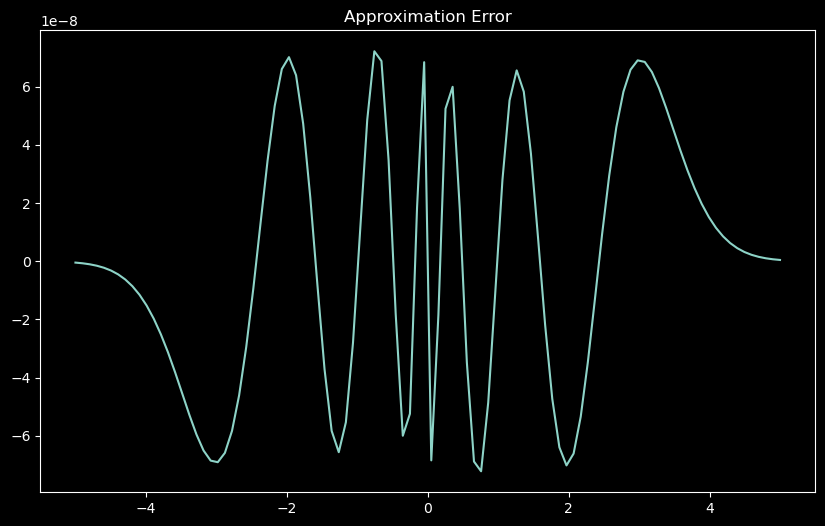

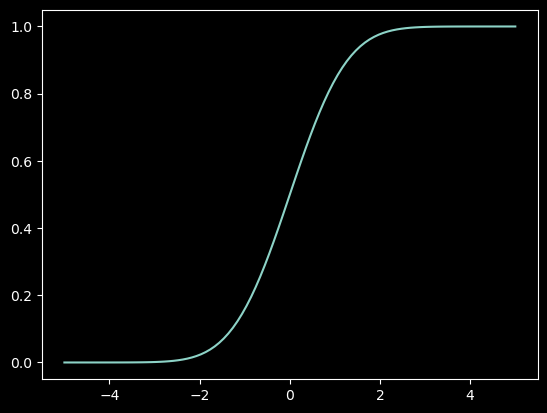

In [2]:
@nb.njit()
def normal_cdf(x):
    t = 1 / (1 + 0.2316419*abs(x))
    summ = 0.319381530*t - 0.356563782*t**2 + 1.781477937*t**3 - 1.821255978*t**4 + 1.330274429*t**5
    if x >= 0:
        return 1 - summ * np.exp(-abs(x)**2 / 2) / np.sqrt(2*np.pi)
    else:
        return summ * np.exp(-abs(x)**2 / 2) / np.sqrt(2*np.pi)

x = np.linspace(-5, 5, 100)
N0 = norm.cdf(x)
N1 = tuple(map(normal_cdf, x))

plt.style.use('dark_background')
plt.figure(figsize=(10,6))
plt.plot(x, N0 - np.array(N1))
plt.title('Approximation Error')
plt.show()

plt.plot(x, N1)

#### 1.2 Newton-Raphson for Implied Volatility

Implied volatility is defined as the volatility level $\sigma$ one needs to plug into the Black-Scholes formula $\mathcal{BS}$ to obtain the market present value $PV^{m k t}$ of the option:

$$
g\left(\sigma_{\text {imp }}\right)=PV^{m k t}(K, T)-\mathcal{BS}\left(t_0=0, S_0 ; K, T, \sigma_{\text {imp }}, r\right)=0 
$$

Given an initial guess for the implied volatility, i.e. $\sigma_{\text {imp }}^{(0)}$, we can find the next approximations, $\sigma_{\text {imp }}^{(k)}, k=1,2, \ldots$, by means of the Newton-Raphson iterative algorythm, as follows

$$
\sigma_{\text {imp }}^{(k+1)}=\sigma_{\text {imp }}^{(k)}-\frac{g\left(\sigma_{\text {imp }}^{(k)}\right)}{g^{\prime}\left(\sigma_{\text {imp }}^{(k)}\right)}, \text { for } k \geq 0 .
$$
where actually the derivative is negative vega:
$$
g^{\prime}\left(\sigma_{\text {imp }}^{(k)} \right) = - \mathcal{V}(\sigma_{\text {imp}}^{(k)})
$$
This algorithm has second order convergence.


#### 1.3 Combined Algorythm (Newton-Raphson + Bisection):

For deep OTM options vega is close to zero - this might lead to instabilities for the Newton-Raphson method. To deal with this, we augment the later with the bisection method.

In [3]:
@nb.njit()
def black_scholes(sigma, S0, K, dt, r, is_call=True):
    d1 = (np.log(S0/K) + (r + sigma**2/2)*dt) / (sigma*np.sqrt(dt))
    d2 = d1 - sigma * np.sqrt(dt)
    p = 1 if is_call else -1
    return p*S0*normal_cdf(p*d1) - p*K*np.exp(-r*dt)*normal_cdf(p*d2)

In [4]:
@nb.njit()
def black_scholes_vega(sigma, S0, K, dt, r):
    d1 = (np.log(S0/K) + (r + sigma**2/2)*dt) / (sigma*np.sqrt(dt))
    return S0 * np.sqrt(dt) * np.exp(-d1**2 / 2) / np.sqrt(2*np.pi)

In [5]:
@nb.njit()
def black_scholes_delta(sigma, S0, K, dt, r, is_call=True):
    d1 = (np.log(S0/K) + (r + sigma**2/2)*dt) / (sigma*np.sqrt(dt))
    p = 1 if is_call else -1
    return p*normal_cdf(p*d1)

In [6]:
@nb.njit()
def g(V_mkt, sigma, dt, S0, K, r, call=True):
    return V_mkt - black_scholes(sigma, S0, K, dt, r, call)


@nb.njit()
def g_prime(sigma, dt, S0, K, r):
    return -black_scholes_vega(sigma, S0, K, dt, r)

@nb.njit()
def implied_vol(V_mkt, S0, K, dt, r, is_call=True, tol=10**-4, sigma_l=10**-8, sigma_r=2):
    if g(V_mkt, sigma_l, dt, S0, K, r, is_call)*g(V_mkt, sigma_r, dt, S0, K, r, is_call) > 0:
        print('no zero at the initial interval')
    else:
        sigma = (sigma_l + sigma_r) / 2
        epsilon = g(V_mkt, sigma, dt, S0, K, r, is_call)
        grad = g_prime(sigma, dt, S0, K, r)
        while abs(epsilon) > tol:   
            if abs(grad) > 1e-6:
                sigma -= epsilon / grad
                if sigma > sigma_r or sigma < sigma_l:
                    if g(V_mkt, sigma_l, dt, S0, K, r, is_call)*epsilon > 0:
                        sigma_l = sigma
                    else:
                        sigma_r = sigma
                    sigma = (sigma_l + sigma_r) / 2
            else:
                if g(V_mkt, sigma_l, dt, S0, K, r, is_call)*epsilon > 0:
                    sigma_l = sigma
                else:
                    sigma_r = sigma
                sigma = (sigma_l + sigma_r) / 2
            
            epsilon = g(V_mkt, sigma, dt, S0, K, r, is_call)
            grad = g_prime(sigma, dt, S0, K, r) 
        return sigma

In [40]:
implied_vol(V_mkt=
            black_scholes(sigma=0.3, S0=100, K=80, dt=0.8, r=0.01, is_call=False), 
                                     S0=100, K=80, dt=0.8, r=0.01, is_call=False,
                sigma_l=0.01, sigma_r=0.9)

0.3000000233632885

<Axes: xlabel='dt'>

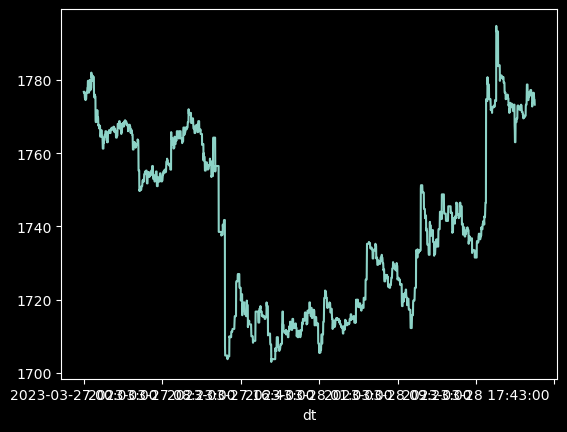

In [56]:
df['eth-2023-03-31']['futures'].plot()

<Axes: xlabel='dt'>

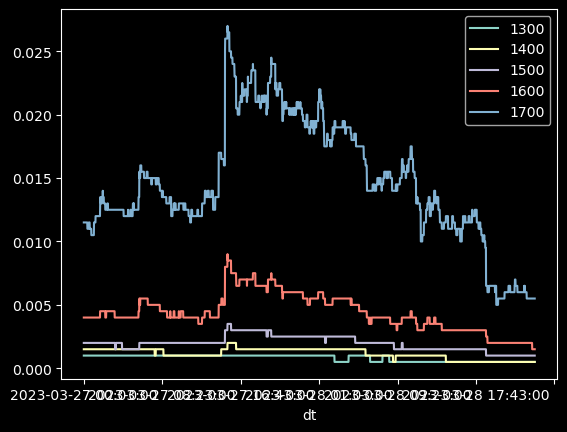

In [55]:
df['eth-2023-03-31-put'].plot()

<Axes: xlabel='dt'>

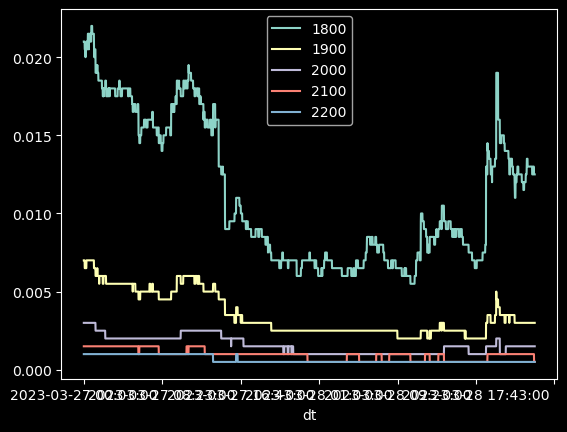

In [57]:
df['eth-2023-03-31-call'].plot()

In [8]:
put_strikes = np.array([1300, 1400, 1500, 1600, 1700])
call_strikes = np.array([1800, 1900, 2000, 2100, 2200])
T = 0.01
forward = 1723.75
puts = np.array([ 1.72375 ,  1.72375 ,  3.4475  ,  6.895   , 26.718125])
calls = np.array([11.204375,  4.309375,  1.72375 ,  0.861875,  0.861875])

In [9]:
@nb.jit()
def get_implied_vols(
    forward,
    maturity,
    strikes,
    forward_values,
    is_call=True
):
    f, dt, Ks = forward, maturity, strikes
    n = len(Ks)
    ivols = np.zeros(n, dtype=np.float64)
    for index in range(n):
        K = Ks[index]
        V_mkt = forward_values[index]
        ivols[index] = implied_vol(V_mkt, f, K, dt, r=0., is_call=is_call)
    return ivols

In [53]:
strikes = np.concatenate((put_strikes, call_strikes))
implied_vols = np.concatenate((
    get_implied_vols(
        forward,
        T,
        put_strikes,
        puts,
        is_call=False
    ),
    get_implied_vols(
        forward,
        T,
        call_strikes,
        calls,
        is_call=True
    )                    
))

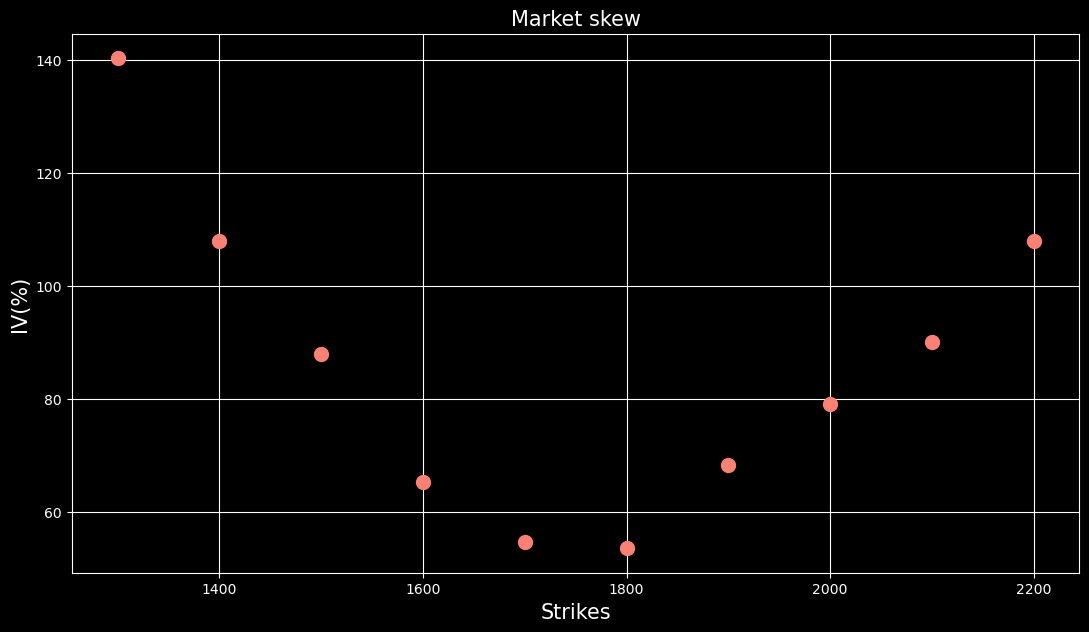

In [54]:
plt.figure(figsize=(13, 7))
plt.plot(strikes, 100*implied_vols, '.C3', markersize=20)
plt.title('Market skew', fontsize=15)
plt.xlabel('Strikes', color='white', fontsize=15)
plt.ylabel('IV(%)', color='white', fontsize=15)
plt.grid()
plt.show()

## 2. Levenberg-Marquardt algorithm

The Levenberg-Marquardt algorithm combines two numerical minimization algorithms: the gradient descent method and the
Gauss-Newton method. In the gradient descent method, the sum of the squared errors is reduced by updating the parameters in the steepest-descent direction. In the
Gauss-Newton method, the sum of the squared errors is reduced by assuming the least
squares function is locally quadratic in the parameters, and finding the minimum of
this quadratic. The Levenberg-Marquardt method acts more like a gradient-descent
method when the parameters are far from their optimal value, and acts more like the
Gauss-Newton method when the parameters are close to their optimal value.

["The Levenberg-Marquardt algorithm for
nonlinear least squares curve-fitting problems" Henri P. Gavin 2022](https://people.duke.edu/~hpgavin/ExperimentalSystems/lm.pdf)

##### Levenberg-Marquardt

$$
\chi^2(\boldsymbol{\theta}) =(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}}(\boldsymbol{\theta}))^{\top} \boldsymbol{W}(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}}(\boldsymbol{\theta}));
$$

$$ W_{ii} = \frac{1}{w_i^2}, \quad \sigma = [\sigma_i], \quad \hat{\sigma} = [\hat{\sigma_i}] $$

##### Gradient descent

$$
\begin{aligned}
\frac{\partial}{\partial \boldsymbol{\theta}} \chi^2 & =-2(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}})^{\top} \boldsymbol{W} \boldsymbol{J}; \quad \boldsymbol{J} = \left[\frac{\partial \hat{\boldsymbol{y}}(\boldsymbol{p})}{\partial \boldsymbol{p}}\right]
\end{aligned}
$$

$$ \text{step: } h_g = \lambda \boldsymbol{J}^T \boldsymbol{W} (\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}}); \quad \lambda > 0 \text{ - learning rate} $$

##### Gauss-Newton Method  $ \quad |h| << 1 $

$$\hat{\boldsymbol{\sigma}}(\boldsymbol{\theta}+\boldsymbol{h}) \approx \hat{\boldsymbol{\sigma}}(\boldsymbol{\theta})+\boldsymbol{J} \boldsymbol{h} \quad \rightarrow \quad \chi^2(\boldsymbol{\theta}+\boldsymbol{h}) \approx \boldsymbol{\sigma}^{\top} \boldsymbol{W} \boldsymbol{\sigma}+\hat{\boldsymbol{\sigma}}^{\top} \boldsymbol{W} \hat{\boldsymbol{\sigma}}-2 \boldsymbol{\sigma}^{\top} \boldsymbol{W} \hat{\boldsymbol{\sigma}}-2(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}})^{\top} \boldsymbol{W} \boldsymbol{J} \boldsymbol{h}+\boldsymbol{h}^{\top} \boldsymbol{J}^{\top} \boldsymbol{W} \boldsymbol{J} \boldsymbol{h} $$

$$
\rightarrow \frac{\partial}{\partial \boldsymbol{h}} \chi^2(\boldsymbol{\theta}+\boldsymbol{h}) \approx-2(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}})^{\top} \boldsymbol{W} \boldsymbol{J}+2 \boldsymbol{h}^{\top} \boldsymbol{J}^{\top} \boldsymbol{W} \boldsymbol{J}
$$

$$
\text{optimal step: } \left[\boldsymbol{J}^{\top} \boldsymbol{W} \boldsymbol{J}\right] \boldsymbol{h}_{\mathrm{gn}}=\boldsymbol{J}^{\top} \boldsymbol{W}(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}})
$$

##### Levenberg Equation

$$
\left[\boldsymbol{J}^{\top} \boldsymbol{W} \boldsymbol{J}+\lambda \boldsymbol{I}\right] \boldsymbol{h}_{\mathrm{lm}}=\boldsymbol{J}^{\top} \boldsymbol{W}(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}})
$$

##### Levenberg-Marquardt equation

$$
\left[\boldsymbol{J}^{\top} \boldsymbol{W} \boldsymbol{J}+\lambda \operatorname{diag}\left(\boldsymbol{J}^{\top} \boldsymbol{W} \boldsymbol{J}\right)\right] \boldsymbol{h}_{\mathrm{Im}}=\boldsymbol{J}^{\top} \boldsymbol{W}(\boldsymbol{y}-\hat{\boldsymbol{y}})
$$

##### Improvement metric

$$
\mu\left(\boldsymbol{h}_{\mathrm{lm}}\right)=\frac{\chi^2(\boldsymbol{\theta})-\chi^2\left(\boldsymbol{\theta}+\boldsymbol{h}_{\mathrm{lm}}\right)}{(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}})^{\top} \boldsymbol{W}(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}})-\left(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}}-\boldsymbol{J} \boldsymbol{h}_{\mathrm{lm}}\right)^{\top} \boldsymbol{W}\left(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}}-\boldsymbol{J} \boldsymbol{h}_{\mathrm{lm}}\right)}
$$

$$
\mu << 1 \quad \rightarrow \quad \text{Gradient descent mode} \quad (\boldsymbol{\lambda} \text{ - is increasing})
$$

$$
\mu >> 1 \quad \rightarrow \quad \text{Gauss-Newton mode } \quad (\boldsymbol{\lambda} \text{ - is decreasing})
$$

$$
\boldsymbol{\mu}_{\lambda}(\boldsymbol{h}_{\mathrm{lm}}) = \frac{\chi^2(\boldsymbol{\theta})-\chi^2\left(\boldsymbol{\theta}+\boldsymbol{h}_{\mathrm{lm}}\right)}{\boldsymbol{h}_{\mathrm{lm}}^{\top}\left(\lambda \operatorname{diag}\left(\boldsymbol{J}^{\top} \boldsymbol{W} J\right) \boldsymbol{h}_{\mathrm{lm}}+\boldsymbol{J}^{\top} \boldsymbol{W}(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}}(\boldsymbol{\theta}))\right)}
$$

##### Step procedure

$$ \boldsymbol{\lambda} = 10^{-2}  \quad \quad \boldsymbol{L} \downarrow = 9 \quad \quad \boldsymbol{L} \uparrow = 11 \quad \quad \boldsymbol{\epsilon} = 10^{-1} $$

$$ \text{solve the L-M equation with  } \boldsymbol{\lambda} \quad \rightarrow \quad \boldsymbol{h}_{\mathrm{lm}} $$

$$
\begin{aligned}
& \text{if } \quad \boldsymbol{N}_{\lambda} (\boldsymbol{h}_{\mathrm{lm}}) > \boldsymbol{\epsilon}: \\
& \quad \quad \boldsymbol{\theta} = \boldsymbol{\theta} + \boldsymbol{h}_{\mathrm{lm}} \\
& \quad \quad \boldsymbol{\lambda} = \max (\frac{\lambda}{L \uparrow}, 10^{-7}) \\
& \text{else: } \\
&  \quad \quad \boldsymbol{\lambda} = \min (\lambda L \uparrow , 10^{7})
\end{aligned}
$$

##### Convergence Criteria

- Gradient convergence: $\max \left|\boldsymbol{J}^{\top} \boldsymbol{W}(\boldsymbol{y}-\hat{\boldsymbol{y}})\right|< 10^{-3}$;
- Parameters convergence: $\max \left|h_i / p_i\right|<10^{-3} ;$ or
- Convergence in $\chi^2:$ uses the value of the reduced $\chi^2, \chi_\nu^2=\chi^2 /(m-n+1)<10^{-1}$.  (where $n$ - sample size, $m$ - param. dimension)

##### Error analysis

$$ \chi_\nu^2 >> 1 \text{ - poor fit };  \quad \chi_\nu^2 \approx 1 \text{ - fit error of sme order as measurement error }; \quad \chi_\nu^2 << 1 \text{ - overfit }; $$

$$ \text{parameters covariance: } (\boldsymbol{J}^{\top} \boldsymbol{W} \boldsymbol{J})^{-1} $$

In [12]:
def levenberg_marquardt(
    Niter: int,
    f: Callable[[np.ndarray], Tuple[np.ndarray, np.ndarray]],
    proj: Callable[[np.ndarray], np.ndarray],
    x0: np.ndarray,
) -> Dict:
    """
    Nonlinear least squares method, Levenberg-Marquardt Method

    Args:
        Niter(int): number of iteration
        f(Callable[ [np.ndarray], Tuple[np.ndarray, np.ndarray]]):
            callable, gets vector of model parameters x as input,
            returns tuple res, J, where res is numpy vector of residues,
            J is jacobian of residues with respect to x
        proj(Callable[ [np.ndarray], np.ndarray ]):
            callable, gets vector of model parameters x,
            returns vector of projected parameters
        x0(np.ndarray): initial parameters
    Returns:
        result(dict): dictionary with results
        result['xs'] contains optimized parameters on each iteration
        result['objective'] contains norm of residuals on each iteration
        result['x'] is optimized parameters
    """
    x = x0.copy()

    mu = 100.0
    nu1 = 2.0
    nu2 = 2.0

    res, J = f(x)
    F = np.linalg.norm(res)

    result = {"xs": [x], "objective": [F], "x": None}
    eps = 1e-5

    for i in range(Niter):
        multipl = J @ J.T
        I = np.diag(np.diag(multipl)) + 1e-5 * np.eye(len(x))
        dx = np.linalg.solve(mu * I + multipl, J @ res)
        x_ = proj(x - dx)
        res_, J_ = f(x_)
        F_ = np.linalg.norm(res_)
        if F_ < F:
            x, F, res, J = x_, F_, res_, J_
            mu /= nu1
            result["xs"].append(x)
            result["objective"].append(F)
        else:
            i -= 1
            mu *= nu2
            continue
        if F < eps:
            break
        result["x"] = x
    return result

## 3. SABR calibration

This is a stochastic volatility model that describes the dynamics of the forward directly in the risk neutral measure:

$$ df_t = \alpha_t f_t^{\beta} dW_t^1 $$ 
$$ d \alpha_t = v \alpha_t dW_t^2$$ 
$$E[dW_t^1, dW_t^2] = \rho dt$$

where $-1 < \rho < 1$ is the vol correlation, $0 \leq \beta \leq 1$ is the CIR exponent and the Wiener processes are independent.

Corrected implied vol parametrisation:
$$x = \ln \frac{f}{K}$$

$$ \sigma_B(x, T) \approx I_B^0(x) (1 + I_H^1(x)T)$$

$$I_H^1(x) = \frac{\alpha^{2} \left(K f\right)^{\beta - 1} \left(1 - \beta\right)^{2}}{24} + \frac{\alpha \beta \rho v \left(K f\right)^{\frac{\beta}{2} - \frac{1}{2}}}{4} + \frac{v^{2} \cdot \left(2 - 3 \rho^{2}\right)}{24}$$

The order zero term is treated below.

For ATM we can approximate the formula as:
$$\sigma_{ATM} = \sigma_{B} (f, f) \approx  \frac{\alpha(1+[\frac{(1-\beta)^2}{24} \frac{\alpha^2}{(f)^{2-2\beta}} + \frac{\rho \beta v \alpha}{4(f)^{(1-\beta)}}+\frac{2-3\rho^2}{24}v^2]T)}{f^{1 - \beta}} $$
The backbone $\beta$ should satisfy:
$$\ln \sigma_{ATM} \approx \ln \alpha - (1 - \beta) \ln {f}$$

Derivatives of $I_H^1(x)$:

$$ \frac{\partial I_H^1(x)}{\partial \alpha} = \frac{\alpha \left(K f\right)^{\beta - 1} \left(1 - \beta\right)^{2}}{12} + \frac{\beta \rho v \left(K f\right)^{\frac{\beta}{2} - \frac{1}{2}}}{4}$$

$$ \frac{\partial I_H^1(x)}{\partial v} = \frac{\alpha \beta \rho \left(K f\right)^{\frac{\beta}{2} - \frac{1}{2}}}{4} + \frac{v \left(2 - 3 \rho^{2}\right)}{12}$$

$$ \frac{\partial I_H^1(x)}{\partial \rho} = \frac{\alpha \beta v \left(K f\right)^{\frac{\beta}{2} - \frac{1}{2}}}{4} - \frac{\rho v^{2}}{4}$$

$$\frac{\partial I_H^1(x)}{\partial f} = \frac{\alpha^2 K^{\beta - 1} (\beta - 1)^3}{24} f^{\beta - 2} + \frac{\alpha \beta \rho v (\frac{\beta}{2} - \frac{1}{2}) K^{\frac{\beta}{2} - \frac{1}{2}}}{4} f^{\frac{\beta}{2}  - \frac{3}{2}}$$



$\textbf{Case 1}: x = 0$ 
$$I_B^0 = \alpha K^{\beta - 1}$$

$$\frac{\partial I_B^0}{\partial \alpha} = K^{\beta - 1}$$
$$\frac{\partial I_B^0}{\partial v} = 0 $$
$$\frac{\partial I_B^0}{\partial \rho} = 0 $$
$$\frac{\partial I_B^0}{\partial f} = 0$$

$\textbf{Case 2}: v = 0$ 
$$I_B^0 = \frac{x\alpha(1 - \beta)}{f^{1 - \beta} - K^{1 - \beta}} $$

$$\frac{\partial I_B^0}{\partial \alpha} = \frac{x(1 - \beta)}{f^{1 - \beta} - K^{1 - \beta}}
$$
$$\frac{\partial I_B^0}{\partial v} = 0 $$
$$\frac{\partial I_B^0}{\partial \rho} = 0 $$
$$\frac{\partial I_B^0}{\partial f} = \frac{\alpha \left(\beta - 1\right) \left(f \left(K^{1 - \beta} - f^{1 - \beta}\right) - f^{2 - \beta} \left(\beta - 1\right) \log{\left(\frac{f}{K} \right)}\right)}{f^{2} \left(K^{1 - \beta} - f^{1 - \beta}\right)^{2}}$$

$\textbf{Case 3}: \beta = 1$ 

$$z = \frac{v x}{\alpha}$$

$$\xi =  \sqrt{- 2 \rho z + z^{2} + 1} $$

$$I_B^0 = \frac{vx}{\ln \left( \frac{\xi + z - \rho}{1 - \rho} \right) } $$

$$\frac{\partial I_B^0}{\partial \alpha} = \frac{v x z}{\alpha \xi \log{\left(\frac{\rho - z - \xi}{\rho - 1} \right)}^{2}}$$


$$\frac{\partial I_B^0}{\partial v} = \frac{x \left(\alpha \xi \log{\left(\frac{\rho - z - \xi}{\rho - 1} \right)} - v x\right)}{\alpha \xi \log{\left(\frac{\rho - z - \xi}{\rho - 1} \right)}^{2}}$$


$$\frac{\partial I_B^0}{\partial \rho} = \frac{v x \left(\left(\rho - 1\right) \left(z + \xi\right) + \left(- \rho + z + \xi\right) \xi\right)}{\left(\rho - 1\right) \left(- \rho + z + \xi\right) \xi \log{\left(\frac{\rho - z - \xi}{\rho - 1} \right)}^{2}} $$

$$\frac{\partial I_B^0}{\partial f} = \frac{v \left(\alpha \xi \log{\left(\frac{\rho - z - \xi}{\rho - 1} \right)} - v x\right)}{\alpha f \xi \log{\left(\frac{\rho - z - \xi}{\rho - 1} \right)}^{2}}$$

$\textbf{Case 4}: \beta < 1$ 

$$z = \frac{v(f^{1 - \beta} - K^{1 - \beta})}{\alpha (1 - \beta)}$$

$$\xi =  \sqrt{- 2 \rho z + z^{2} + 1} $$

$$I_B^0 = \frac{vx}{\ln \left( \frac{\xi + z - \rho}{1 - \rho} \right) } $$

$$\frac{\partial I_B^0}{\partial \alpha} = \frac{v x z}{\alpha \xi \log{\left(\frac{\rho - z - \xi}{\rho - 1} \right)}^{2}} $$


$$\frac{\partial I_B^0}{\partial v} = - \frac{v x \left(\frac{- \frac{\rho z}{v} + \frac{z^{2}}{v}}{\xi} + \frac{z}{v}\right)}{\left(- \rho + z + \xi\right) \log{\left(\frac{- \rho + z + \xi}{1 - \rho} \right)}^{2}} + \frac{x}{\log{\left(\frac{- \rho + z + \xi}{1 - \rho} \right)}}$$


$$\frac{\partial I_B^0}{\partial \rho} = - \frac{v x \left(1 - \rho\right) \left(\frac{- \frac{z}{\xi} - 1}{1 - \rho} + \frac{- \rho + z + \xi}{\left(1 - \rho\right)^{2}}\right)}{\left(- \rho + z + \xi\right) \log{\left(\frac{- \rho + z + \xi}{1 - \rho} \right)}^{2}} $$

$$\frac{\partial I_B^0}{\partial f} = \frac{v \left(\alpha f \left(- \rho + z + \xi\right) \xi \log{\left(\frac{\rho - z - \xi}{\rho - 1} \right)} + f^{2 - \beta} v x \left(\rho - z - \xi \right)\right)}{\alpha f^{2} \left(- \rho + z + \xi\right) \xi \log{\left(\frac{\rho - z - \xi}{\rho - 1} \right)}^{2}}$$

For $C = C_B(\sigma_B)$, present or forward value of the call with $C_B$ the Black-Scholes formula and $\sigma_B$ the implied vol, greeks read:

* Delta (for the call):
$$\Delta_C =  \frac{\partial C}{\partial f} =  \frac{\partial C_B}{\partial f} + \frac{\partial C_B}{\partial \sigma_B} \cdot \left( \frac{\partial \sigma_B}{\partial f} + \frac{\partial \sigma_B}{\partial \alpha}  \frac{\rho v}{f^\beta} \right) = $$
$$ = \Delta_{C,BSM} + \mathcal{V}_{BSM} \cdot \left( \frac{\partial \sigma_B}{\partial f} + \frac{\partial \sigma_B}{\partial \alpha}  \frac{\rho v}{f^\beta} \right) = $$
$$N(d_1) + fN'(d_{1}){\sqrt {T-t}} \cdot \left( \frac{\partial \sigma_B}{\partial f} + \frac{\partial \sigma_B}{\partial \alpha}  \frac{\rho v}{f^\beta} \right)$$
For the put one can use the put-call parity:
$$\Delta_{P} = \Delta_{C} - 1$$


* Vega (straddle):

$$\mathcal{V} = \frac{\partial C}{\partial \alpha} = \frac{\partial C_B}{\partial \sigma_B} \cdot \left( 
 \frac{\partial \sigma_B}{\partial \alpha} + \frac{\partial \sigma_B}{\partial f} \cdot \frac{\rho f^\beta}{v}\right) = $$
 $$ = \mathcal{V}_{BSM} \cdot \left( 
 \frac{\partial \sigma_B}{\partial \alpha} + \frac{\partial \sigma_B}{\partial f} \cdot \frac{\rho f^\beta}{v}\right) = $$
 $$ = fN'(d_{1}){\sqrt {T-t}} \cdot \left( 
 \frac{\partial \sigma_B}{\partial \alpha} + \frac{\partial \sigma_B}{\partial f} \cdot \frac{\rho f^\beta}{v}\right)$$
 
 * Rega (risk reversal):
 $$ \mathcal{R} =\frac{ \partial C}{\partial  \rho} = \frac{\partial C}{\partial \sigma_B} \frac{\partial \sigma_B}{\partial \rho} = \mathcal{V}_{BSM} \frac{\partial \sigma_B}{\partial \rho}$$

 * Sega (butterfly):
$$ \mathcal{S} =\frac{ \partial C}{\partial  v} = \frac{\partial C}{\partial \sigma_B} \frac{\partial \sigma_B}{\partial v} = \mathcal{V}_{BSM} \frac{\partial \sigma_B}{\partial v}$$

In [13]:
beta = 0.95

In [61]:
T

0.01

In [14]:
@nb.njit()
def jacobian_sabr(
    forward,
    maturity,
    strikes,
    backbone,
    params
):
    f, T, Ks = forward, maturity, strikes
    n = len(Ks)
    beta = backbone
    alpha, rho, v = params[0], params[1], params[2]
    ddalpha = np.zeros(n, dtype=np.float64)
    ddv = np.zeros(n, dtype=np.float64)
    ddrho = np.zeros(n, dtype=np.float64)
    for index in range(n):
        K = Ks[index]
        x = np.log(f / K)
        I_H = (
            alpha**2 * (K * f) ** (beta - 1) * (1 - beta) ** 2 / 24
            + alpha * beta * rho * v * (K * f) ** (beta / 2 - 1 / 2) / 4
            + v**2 * (2 - 3 * rho**2) / 24
        )
        
        dI_H_alpha = (
            alpha * (K * f) ** (beta - 1) * (1 - beta) ** 2 / 12
            + beta * rho * v * (K * f) ** (beta / 2 - 1 / 2) / 4
        )
        
        dI_H_rho = (
            alpha * beta * v * (K * f) ** (beta / 2 + -1 / 2) / 4 - rho * v**2 / 4
        )
        
        dI_h_v = (
            alpha * beta * rho * (K * f) ** (beta / 2 + -1 / 2) / 4
            + v * (2 - 3 * rho**2) / 12
        )
    

        if x == 0.0:
            I_B = alpha * K ** (beta - 1)
            B_alpha = K ** (beta - 1)
            B_v = 0.0
            B_rho = 0.0

        elif v == 0.0:
            I_B = alpha * (1 - beta) * x / (f ** (1 - beta) - (K ** (1 - beta)))
            B_alpha = (beta - 1) * x / (K ** (1 - beta) - f ** (1 - beta))
            B_v = 0.0
            B_rho = 0.0

        elif beta == 1.0:
            z = v * x / alpha
            sqrt = np.sqrt(1 - 2 * rho * z + z**2)
            I_B = v * x / (np.log((sqrt + z - rho) / (1 - rho)))
            B_alpha = (
                v * x * z / (alpha * sqrt * np.log((rho - z - sqrt) / (rho - 1)) ** 2)
            )
            B_v = (
                x
                * (alpha * sqrt * np.log((rho - z - sqrt) / (rho - 1)) - v * x)
                / (alpha * sqrt * np.log((rho - z - sqrt) / (rho - 1)) ** 2)
            )
            B_rho = (
                v
                * x
                * ((rho - 1) * (z + sqrt) + (-rho + z + sqrt) * sqrt)
                / (
                    (rho - 1)
                    * (-rho + z + sqrt)
                    * sqrt
                    * np.log((rho - z - sqrt) / (rho - 1)) ** 2
                )
            )

        elif beta < 1.0:
            z = v * (f ** (1 - beta) - K ** (1 - beta)) / (alpha * (1 - beta))
            sqrt = np.sqrt(1 - 2 * rho * z + z**2)
            I_B = v * (-(K ** (1 - beta)) + f ** (1 - beta)) / (alpha * (1 - beta))
            B_alpha = (
                v * x * z / (alpha * sqrt * np.log((rho - z - sqrt) / (rho - 1)) ** 2)
            )
            B_v = -v * x * ((-rho * z / v + z**2 / v) / sqrt + z / v) / (
                (-rho + z + sqrt) * np.log((-rho + z + sqrt) / (1 - rho)) ** 2
            ) + x / np.log((-rho + z + sqrt) / (1 - rho))

            B_rho = (
                -v
                * x
                * (1 - rho)
                * ((-z / sqrt - 1) / (1 - rho) + (-rho + z + sqrt) / (1 - rho) ** 2)
                / ((-rho + z + sqrt) * np.log((-rho + z + sqrt) / (1 - rho)) ** 2)
            )

        sig_alpha = B_alpha * (1 + I_H * T) + dI_H_alpha * I_B * T
        sig_v = B_v * (1 + I_H * T) + dI_h_v * I_B * T
        sig_rho = B_rho * (1 + I_H * T) + dI_H_rho * I_B * T

        ddalpha[index] = sig_alpha
        ddv[index] = sig_v
        ddrho[index] = sig_rho
        
    return ddalpha, ddrho, ddv

In [15]:
@nb.njit()
def vol_sabr(
    forward,
    maturity,
    strikes,
    backbone,
    params,
    compute_risk=False
):
    f, T, Ks = forward, maturity, strikes
    n = len(Ks)
    beta = backbone
    alpha, rho, v = params[0], params[1], params[2]
    
    if compute_risk:
        dsigma_dalphas, dsigma_drhos, dsigma_dvs = jacobian_sabr(
            forward,
            maturity,
            strikes,
            backbone,
            params)
    
    sigmas = np.zeros(n, dtype=np.float64)
    
    if compute_risk:
        deltas = np.zeros(n, dtype=np.float64) 
        vegas = np.zeros(n, dtype=np.float64)
        regas = np.zeros(n, dtype=np.float64) 
        segas = np.zeros(n, dtype=np.float64) 
    
    for index in range(n):
        K = Ks[index]
        x = np.log(f / K)
        dIH1dF = alpha**2 * (K * f) ** (beta - 1) * (1 - beta) ** 2 * (beta - 1) / (
            24 * f
        ) + alpha * beta * rho * v * (K * f) ** (beta / 2 - 1 / 2) * (
            beta / 2 - 1 / 2
        ) / (
            4 * f
        )

        I_H_1 = (
            alpha**2 * (K * f) ** (beta - 1) * (1 - beta) ** 2 / 24
            + alpha * beta * rho * v * (K * f) ** (beta / 2 + -1 / 2) / 4
            + v**2 * (2 - 3 * rho**2) / 24
        )

        if x == 0.0:
            I_B_0 = K ** (beta - 1) * alpha
            dI_B_0_dF = 0.0

        elif v == 0.0:
            I_B_0 = alpha * (1 - beta) * x / (-(K ** (1 - beta)) + f ** (1 - beta))
            dI_B_0_dF = (
                alpha
                * (beta - 1)
                * (
                    f * (K ** (1 - beta) - f ** (1 - beta))
                    - f ** (2 - beta) * (beta - 1) * x
                )
                / (f**2 * (K ** (1 - beta) - f ** (1 - beta)) ** 2)
            )

        else:
            if beta == 1.0:
                z = v * x / alpha
                sqrt = np.sqrt(1 - 2 * rho * z + z**2)

                dI_B_0_dF = (
                    v
                    * (alpha * sqrt * np.log((rho - z - sqrt) / (rho - 1)) - v * x)
                    / (alpha * f * sqrt * np.log((rho - z - sqrt) / (rho - 1)) ** 2)
                )

            elif beta < 1.0:
                z = v * (f ** (1 - beta) - K ** (1 - beta)) / (alpha * (1 - beta))
                sqrt = np.sqrt(1 - 2 * rho * z + z**2)
                dI_B_0_dF = (
                    v
                    * (
                        alpha
                        * f
                        * (-rho + z + sqrt)
                        * sqrt
                        * np.log((rho - z - sqrt) / (rho - 1))
                        + f ** (2 - beta) * v * x * (rho - z - sqrt)
                    )
                    / (
                        alpha
                        * f**2
                        * (-rho + z + sqrt)
                        * sqrt
                        * np.log((rho - z - sqrt) / (rho - 1)) ** 2
                    )
                )

            I_B_0 = v * x / (np.log((sqrt + z - rho) / (1 - rho)))

        sigma = I_B_0 * (1 + I_H_1 * T)
        sigmas[index] = sigma
        
        if compute_risk:
            dsigma_df = dI_B_0_dF * (1 + I_H_1 * T) + dIH1dF * I_B_0 * T
            vega_bsm = black_scholes_vega(sigma, f, K, T, r=0.)
            delta_bsm = black_scholes_delta(sigma, f, K, T, r=0., is_call=True)
        
            dsigma_dalpha, dsigma_drho, dsigma_dv =\
                dsigma_dalphas[index], dsigma_drhos[index], dsigma_dvs[index]
            # call delta, for put don't forget to take 1-delta
            deltas[index] = delta_bsm + vega_bsm*(dsigma_df + dsigma_dalpha*rho*v/f**beta)

            vegas[index] = vega_bsm*(dsigma_dalpha + dsigma_df*rho*f**beta/v)
            regas[index] = vega_bsm*dsigma_drho
            segas[index] = vega_bsm*dsigma_dv
    
    greeks = (deltas, vegas, regas, segas) if compute_risk else None

    return sigmas, greeks

In [85]:
def calibrate_sabr(
    forward,
    maturity,
    strikes,
    implied_vols,
    backbone,
    initial_params = np.array([1., -0.1, 0.0])
):
    
    def clip_params(params: np.ndarray) -> np.ndarray:
        eps = 1e-4
        alpha, rho, v = params[0], params[1], params[2]
        alpha = np.clip(alpha, eps, 50.0)
        v = np.clip(v, eps, 50.0)
        rho = np.clip(rho, -1.0 + eps, 1.0 - eps)
        sabr_params = np.array([alpha, rho, v])
        return sabr_params
    
    def get_residuals(params: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        J = np.stack( 
            jacobian_sabr(
                forward,
                maturity,
                strikes,
                backbone,
                params
            )
        )
        iv, _ = vol_sabr(
            forward,
            maturity,
            strikes,
            backbone,
            params,
            compute_risk=False
        )
        weights = np.ones_like(strikes)
        weights = weights / np.sum(weights)
        res = iv - implied_vols
        return res * weights, J @ np.diag(weights)
    
    res = levenberg_marquardt(500, get_residuals, clip_params, initial_params)
    calibrated_params = np.array(res["x"], dtype=np.float64)
    error = res["objective"][-1]
    
    return calibrated_params, error  

In [62]:
calibrated_params, error = calibrate_sabr(
    forward,
    T,
    strikes,
    implied_vols,
    beta)
error

0.013079257225396046

In [63]:
calibrated_params

array([ 0.60941882, -0.15460907, 11.22350735])

In [23]:
iv, greeks =  vol_sabr(
    forward,
    T,
    strikes,
    beta,
    calibrated_params,
    compute_risk=True)

In [66]:
test_strikes = np.linspace(strikes[0], strikes[-1], 100)

In [ ]:
tparams = calibrated_params[2]

In [67]:
test_iv, _ =  vol_sabr(
    forward,
    T,
    test_strikes,
    beta,
    calibrated_params,
    compute_risk=False)

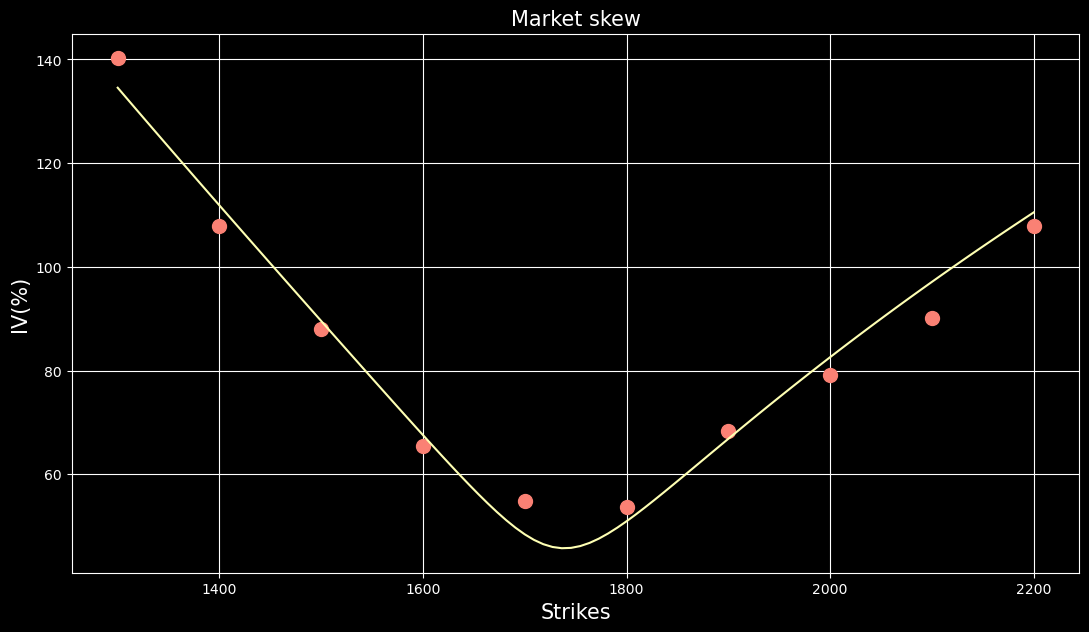

In [69]:
plt.figure(figsize=(13, 7))
plt.plot(strikes, 100*implied_vols, '.C3', markersize=20)
plt.plot(test_strikes, 100*test_iv, 'C1')
plt.title('Market skew', fontsize=15)
plt.xlabel('Strikes', color='white', fontsize=15)
plt.ylabel('IV(%)', color='white', fontsize=15)
plt.grid()
plt.show()

In [73]:
df

eth-perpetual eth-2023-03-31 eth-2023-03-31-put          \
                             spot        futures               1300    1400   
dt                                                                            
2023-03-27 00:03:00       1776.15        1776.75             0.0010  0.0015   
2023-03-27 00:04:00       1776.15        1776.50             0.0010  0.0015   
2023-03-27 00:05:00       1776.15        1776.50             0.0010  0.0015   
2023-03-27 00:06:00       1776.15        1776.50             0.0010  0.0015   
2023-03-27 00:07:00       1776.15        1776.50             0.0010  0.0015   
...                           ...            ...                ...     ...   
2023-03-28 23:53:00       1775.20        1774.75             0.0005  0.0005   
2023-03-28 23:54:00       1774.95        1774.50             0.0005  0.0005   
2023-03-28 23:55:00       1774.95        1774.50             0.0005  0.0005   
2023-03-28 23:56:00       1774.95        1774.50             0.0005  0.0005   
2023-03-28 23:57:00       1773.65        1773.25             0.0005  0.0005   

                                           eth-2023-03-31-call                 \
                      1500    1600    1700                1800   1900    2000   
dt                                                                              
2023-03-27 00:03:00  0.002  0.0040  0.0115              0.0210  0.007  0.0030   
2023-03-27 00:04:00  0.002  0.0040  0.0115              0.0210  0.007  0.0030   
2023-03-27 00:05:00  0.002  0.0040  0.0115              0.0210  0.007  0.0030   
2023-03-27 00:06:00  0.002  0.0040  0.0115              0.0210  0.007  0.0030   
2023-03-27 00:07:00  0.002  0.0040  0.0115              0.0210  0.007  0.0030   
...                    ...     ...     ...                 ...    ...     ...   
2023-03-28 23:53:00  0.001  0.0015  0.0055              0.0125  0.003  0.0015   
2023-03-28 23:54:00  0.001  0.0015  0.0055              0.0125  0.003  0.0015   
2023-03-28 23:55:00  0.001  0.0015  0.0055              0.0125  0.003  0.0015   
2023-03-28 23:56:00  0.001  0.0015  0.0055              0.0125  0.003  0.0015   
2023-03-28 23:57:00  0.001  0.0015  0.0055              0.0125  0.003  0.0015   

                                     
                       2100    2200  
dt                                   
2023-03-27 00:03:00  0.0015  0.0010  
2023-03-27 00:04:00  0.0015  0.0010  
2023-03-27 00:05:00  0.0015  0.0010  
2023-03-27 00:06:00  0.0015  0.0010  
2023-03-27 00:07:00  0.0015  0.0010  
...                     ...     ...  
2023-03-28 23:53:00  0.0005  0.0005  
2023-03-28 23:54:00  0.0005  0.0005  
2023-03-28 23:55:00  0.0005  0.0005  
2023-03-28 23:56:00  0.0005  0.0005  
2023-03-28 23:57:00  0.0005  0.0005  

[2875 rows x 12 columns]

In [25]:
implied_vols

array([1.40243358, 1.07933576, 0.88013995, 0.65409296, 0.54770113,
       0.53615127, 0.68399338, 0.79189826, 0.90156026, 1.07914141])

In [74]:
calibrated_params

array([ 0.60941882, -0.15460907, 11.22350735])

#### Unexplained PnL 

Given the forward value $FV_t$, $f_t$ and calibrated parameters $\alpha_t$, $\rho_t$ and $v_t$, we observe the next update in the market $FV_{t+1}$, $f_{t+1}$ and the parameters $\alpha_{t+1}$, $\rho_{t+1}$ and $v_{t+1}$, and we want to measure:

$$
FV_{t+1} - FV_t = \Delta_{FV} \cdot (f_{t+1} - f_t) + \frac{1}{2} \Gamma _{FV} \cdot(f_{t+1} - f_t)^2 + \mathcal{V}_{FV}\cdot(\alpha_{t+1} - \alpha_t) + \mathcal{R}_{FV}\cdot(\rho_{t+1} - \rho_t) + \mathcal{S}_{FV}\cdot(v_{t+1} - v_t) + \text{Unexplained PnL} 
$$

In [82]:
new_forward = 1723.25
new_puts = np.array([ 0.861625,  1.72325 ,  3.4465  ,  6.893   , 26.710375])
new_calls = np.array([11.201125,  4.308125,  1.72325 ,  1.72325 ,  0.861625])

In [83]:
new_implied_vols = np.concatenate((
    get_implied_vols(
        new_forward,
        T,
        put_strikes,
        new_puts,
        is_call=False
    ),
    get_implied_vols(
        new_forward,
        T,
        call_strikes,
        new_calls,
        is_call=True
    )                    
))

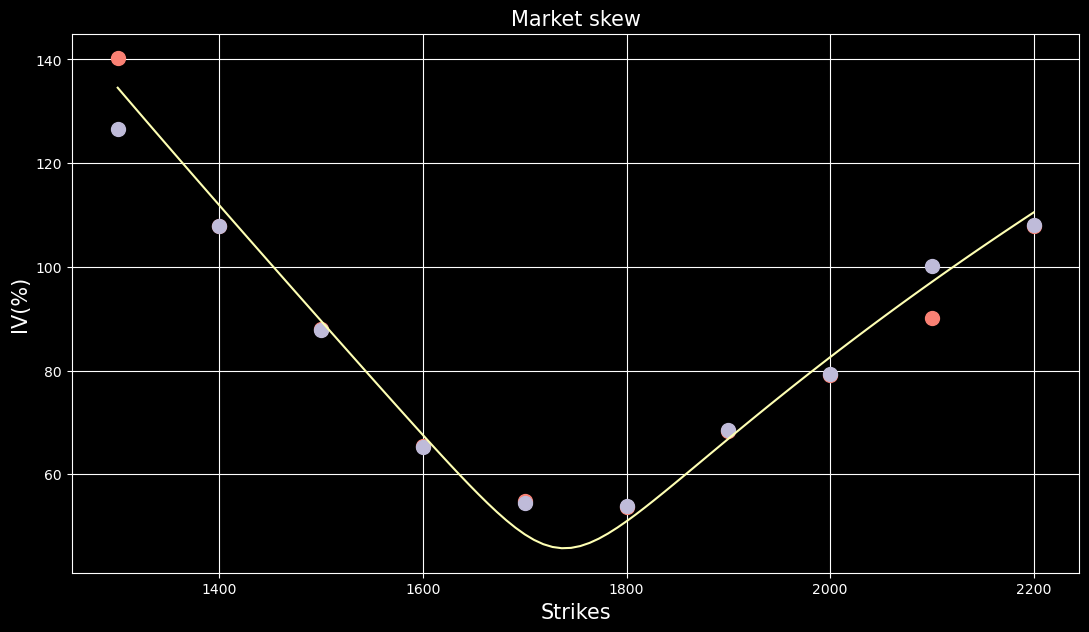

In [84]:
plt.figure(figsize=(13, 7))
plt.plot(strikes, 100*implied_vols, '.C3', markersize=20)
plt.plot(strikes, 100*new_implied_vols, '.C2', markersize=20)
plt.plot(test_strikes, 100*test_iv, 'C1')
plt.title('Market skew', fontsize=15)
plt.xlabel('Strikes', color='white', fontsize=15)
plt.ylabel('IV(%)', color='white', fontsize=15)
plt.grid()
plt.show()

In [86]:
new_calibrated_params, error = calibrate_sabr(
    new_forward,
    T,
    strikes,
    new_implied_vols,
    beta,
    calibrated_params)
error

0.00656489543083605

In [87]:
new_calibrated_params - calibrated_params

array([ 0.08099565,  0.04840708, -1.25834538])

In [88]:
new_test_iv, _ =  vol_sabr(
    new_forward,
    T,
    test_strikes,
    beta,
    new_calibrated_params,
    compute_risk=False)

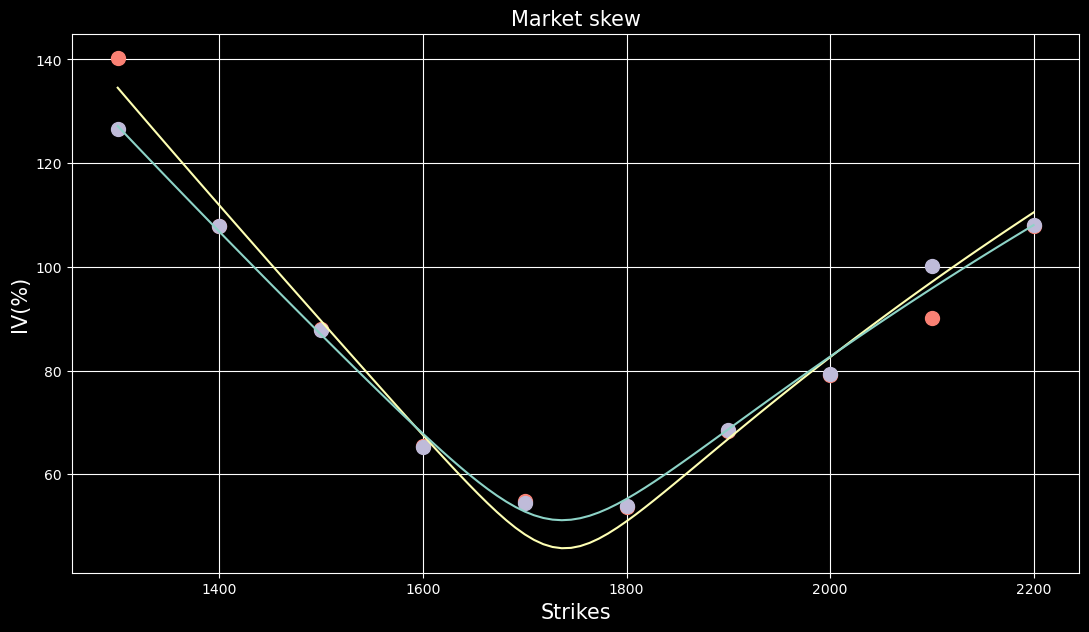

In [89]:
plt.figure(figsize=(13, 7))
plt.plot(strikes, 100*implied_vols, '.C3', markersize=20)
plt.plot(strikes, 100*new_implied_vols, '.C2', markersize=20)
plt.plot(test_strikes, 100*test_iv, 'C1')
plt.plot(test_strikes, 100*new_test_iv, 'C0')
plt.title('Market skew', fontsize=15)
plt.xlabel('Strikes', color='white', fontsize=15)
plt.ylabel('IV(%)', color='white', fontsize=15)
plt.grid()
plt.show()

In [94]:
iv, greeks =  vol_sabr(
    new_forward,
    T,
    np.array([1750.0]),
    beta,
    new_calibrated_params,
    compute_risk=True)

In [95]:
delta, vega, rega, sega = greeks

In [96]:
delta

array([0.32625537])

In [97]:
vega

array([48.73619532])

In [93]:
np.array([1750]).dtype

dtype('int64')

## 4. Heston calibration
This is a stochastic volatility model for the forward dynamics in the risk neutral measure, and CIR dynamics for the variance:
$$
\left\{
\begin{array}{l}
    \text{d}X_t =  \sqrt{V_t} X_t \text{d}W_t^X,  \\
    \text{d}V_t =  \kappa (\theta - V_t)\text{d}t + \varepsilon \sqrt{V_t} \text{d} W_t^V,
\end{array}\right.
$$

where underlying Brownian motions are correlated:
$$ \text{d} W_t^V = \rho\text{d}W_t^X + \sqrt{1-\rho^2} \text{d}W_t,$$
$$ -1 < \rho < 1 $$

The forward price of a call option is given by:
$$
\text{FV}_C(t_0, T, K) = X_{t_0} H(\sqrt{-1}) - K \cdot H(0)
$$
where
$$
H(z) = \frac{1}{2} + \frac{1}{\pi} \int^{\infty}_0 \mathbf{Re} \left[ \frac{e^{u\sqrt{-1} \log \frac{X_{t_0}}{K}}}{u\sqrt{-1}} \phi(u-z,T) \right]\text{d}u
$$
with 
$$
\phi(u,T) = \exp \left( - \frac{\kappa\theta\rho T u\sqrt{-1} }{\varepsilon} - A + \frac{2 \kappa \theta }{\varepsilon^2}D\right).
$$
Here $A = A_1 / A_2$:
$$
A_1 = (u^2 + u\sqrt{-1}) \sinh \frac{q T}{2}, \quad q = \sqrt{ \xi^2 + \varepsilon^2 (u^2 + u\sqrt{-1})}, \quad \xi = \kappa - \varepsilon\rho u\sqrt{-1}
$$
$$
\log A_2 = \frac{q T}{2} + \log \left( \frac{q +\xi}{2 V_{t_0}} + \frac{q  - \xi}{2V_{t_0}}e^{-q T}\right),
$$

and
$$
D = \log \frac{q}{V_{t_0}} + \frac{\kappa T}{2} - \log A_2.
$$

The integral above can be truncated to $(0,200)$ and evaluated via Gaussian quadrature at 64 nodes for $10^{-10}$ accuracy.

#### 4.1 Delta computation
See that:

$$\text{FV}_C(\lambda X_{t_0}, T, \lambda K) = \lambda \text{FV}_C(X_{t_0}, T, K).$$

So, formula is homogeneous of order one. Differentiating both sides with respect to $\lambda$:

$$X_{t_0} \frac{\partial \text{FV}_C}{\partial X_{t_0}} + K \frac{\partial \text{FV}_C}{\partial K} = \text{FV}_C.$$

Comparing with equation for call-option:

$$\Delta = \frac{\partial \text{FV}_C}{\partial X_{t_0}} = H(i).$$

### References
* Hagan, P. S. et al. *Implied volatility formulas for Heston models.* Wilmott 2018.98 (2018)
* Hagan, P.S., Lesniewski, A.S. and Woodward, D.E., *Managing vol surfaces*. Wilmott (93), pp.24-43, (2018)
* Bartlett, B. *Hedging Under SABR Model.* Wilmott Magazine, (2006)
* Oblój, J. *Fine-Tune Your Smile: Correction to Hagan et al*. preprint arXiv:0708.0998 (2007)
* Paulot, L. *Asymptotic implied volatility at the second order with application to the SABR model.* In Large Deviations and Asymptotic Methods in Finance (pp. 37-69). Springer, Cham. (2015)
* Henry-Labordere, P. *A general asymptotic implied volatility for stochastic volatility models.* http://arxiv.org/abs/cond-mat/0504317 (2005)